# Interpreter of Handwritten Script (IHandS)

By Sri Sagar Abhishek, Yeluri - May 09, 2018

__Note:__ This notebook also has a slide version, which is better to look at when not executing any code blocks. The command to run the notebook in slide mode is 

```jupyter nbconvert ProjectCS445.ipynb --to slides --post serve```. 

Runnig this command will open the notebook in slides modes and then clicking on the right arrow will move you to the next Markdown or code cell.

##  Introduction

IHandS stands for Interpreter of Handwritten Script. As the name suggests it interprets the handwritten text that is taken from a page given as an input to it. A page has text written on in it, between the ruled lines. The ruled lines are necessary as that acts as a guide for the image processing code to understand the bounds of each possible line in the given page. As the program can read multiple lines of script, this was necessary to set the boundaries of the lines, and also to have a maximum font size limit for any text written.

This tool, will help in transcribing handwritten notes in fields like academia, healthcare, etc. where there is a large number of documents that could be uploaded online. However uploading their pictures directly will take up a huge amount of storage and also the time consumed to store such large pictures is a lot. So instead this tool aids people in generating a simple text file as long as the handwriting is legible and the ruled lines are properly parallel to the top and the bottom edges of the image.

The given input image is processed, where the ruled lines are each viewed separately and the code implemented by me, processes each line and seperates out each letter and uses that for prediction. For this tool, i used the EMNIST dataset, which can be found attached in the tar file for your reference, for training. The dataset contains pixel values of the handwritten letters. I used two different methods for training. I used the MultiLayer Perceptron Classifier and the Convolutional Neural Networks to classify the letters. The Convolutional Neural Network provided better results. We will discuss the methods used and the results they provided in the sections below.

## Methods used

EMNIST dataset stands for Extended Modified National Institute of Standards and Technology dataset. This is an extended version of the MNIST dataset which is a collection of handwritten digits. Of the multiple .csv files available in the emnist folder, i used the `emnist-letters-train.csv` for training. It has a total of 88800 entries for all the 26 letters, both in Uppercase and Lowercase. Each of the letters is mapped to a class which is the position of the letter in the alphabets list, i.e. A is 1, B is 2, and so on. The classes are independent of the case of the letters, that is a letter whether in lower or upper case is mapped to the same class.

The EMNIST dataset is used only for the training purpose but it is not used for actual testing purposes. For the real test, we use the input given as an image. An image is opened and read. Two forms of the image is used. We use the binary form of the image for separarting the lines, and then separating each letter within the lines. Separation of lines is done by storing the pixel position where a line appears, and separation of characters is done by storing both the starting and the ending position of the characters in two different lists.

We then send the image of each letter as the test data to the model we already obtained from the training, and predict the letter, and then using the mapping list place the append the appropriate character to the string word. 

Let us go through each code block in detail.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import pickle
import gzip
from sklearn.neural_network import MLPClassifier
import pandas as pd
import cv2
from IPython.display import display, Image
from PIL import Image
from skimage import data,morphology
from skimage.transform import resize,rescale
from scipy import ndimage
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
from keras.models import load_model
import h5py
import os

Using TensorFlow backend.


We are setting the batch_size as 64, epochs as 20, and number of classes as 27. Even though we only have 26 alphabets in English language, when we use the np_utils.to_categorical, there are 27 classes that are generated, as 0 even though not present in the dataset as a target value is also conisdered by np_utils.to_categorical. We use this to our advantage, as when the model fails to predict the letter, it returns a 0, and the character at 0th position in the mapping list is a ' ' (space). So in case of failure to predict a letter, instead of placing a random letter, we place a space to avoid confusion.

We also store the model trained for future use, as the model training takes a long time and can be avoided this way.

In [3]:
batch_size = 64
epochs = 25
num_classes = 27
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cnn_IHandS_new1.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

In [4]:
mapping = [' ','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'W', 'V', 'X', 'Y', 'Z']

We create a Convolutional Neural Network model with three layers with first layer having 32 - 3X3 filters, second layer having 64 - 3X3 filters, and a third layer having 128 - 3X3 filters. At the end of each layer, we also have a MaxPooling2D layer of size 2X2. The idea for this particular structure was obtained from [this](https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python ) site which uses the fashion-mnist dataset. The activation function used is softmax. 

In [5]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2, 2), padding='same'))
cnn_model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
cnn_model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))                  
cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='linear'))
cnn_model.add(LeakyReLU(alpha=0.1))                  
cnn_model.add(Dense(num_classes, activation='softmax'))

We then compile the model, using the Adam optimizer of Keras, with a learning rate of 0.0001, which i found to be the most efficient in my runs, where i used learning rate of 0.001, 0.0001, 0.00005, 0.00001 and 0.000001.

In [6]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr = 0.0001),metrics=['accuracy'])

In [7]:
dataletters = pd.read_csv("emnist/emnist-letters-train.csv",header = None, delimiter = ',')
dataletters.head()
datacopy = dataletters.values[:,1:]
train_X = datacopy.reshape(-1, 28,28, 1)
train_label = np_utils.to_categorical(dataletters.values[:,0:1])
print(train_X.shape,train_label.shape)

(88800, 28, 28, 1) (88800, 27)


In [8]:
run_new_model = False
if run_new_model == True:
    with h5py.File(model_path, 'w') as f:
        cnn_train = cnn_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1)
    cnn_model.save(model_path)
else:
    cnn_model = load_model('/Users/abhishek/Downloads/YELURI-Project/saved_models/keras_cnn_IHandS.h5')

In [9]:
Y = cnn_model.predict(train_X)
Y = np.argmax(Y, axis = 1)
print("Accuracy of EMNIST training data using CNN is : ",np.sum(Y == dataletters.values[:,0])/len(dataletters.values[:,0])*100)

Accuracy of EMNIST training data using CNN is :  97.8817567568


In the below code segment we separate the lines to be read for letters, using the ruled lines as our reference. We use the binary image and identify the row of pixels, where more than 80% of the pixels is black, which contributes to a line. The reason to use 80% is that if the picture is not having the lines perfectly parallel to the top and the bottom edges, 80% would be aprroximately how many pixels would be black. This works under the assumption that we don't have so many characters in a single line, that the pixels in the characters itself contributes to 80% of black pixels in a line.

[1, 81, 163, 244, 326, 408, 490, 571, 654, 734, 816, 897, 979, 1061, 1143, 1226, 1308, 1391, 1474, 1556, 1639, 1722]


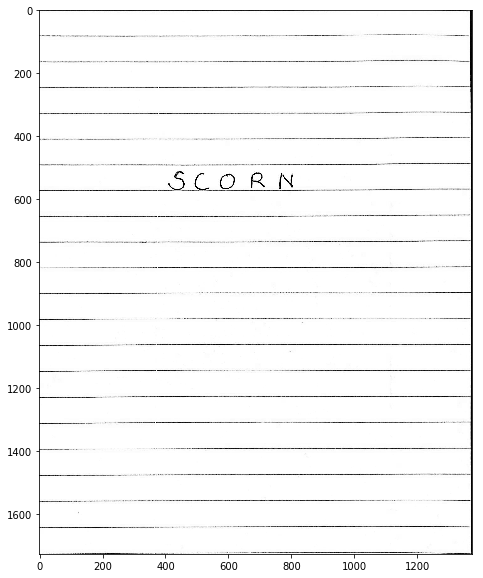

In [35]:
img = Image.open("LetterBig1.jpg")
img.load()
image1 = img.convert('1')
data = np.asarray( img, dtype="int32" )
data1 = np.asarray( image1, dtype="int32" )
imageL = img.convert('L')
dataL = np.asarray( imageL, dtype="int32" )

im = Image.fromarray(dataL[:,:].astype('uint8'))
plt.figure(figsize=(10,10))
plt.imshow(im,interpolation='nearest',cmap='gray')
lines=[]
i=0
while i<dataL.shape[0]:#data1.shape[0]):
    if np.sum(data1[i]) <= 0.80*data1.shape[1]:
        lines.append(i)
        i = i+(round((data1.shape[1]/100)*2))
    else:
        i += 1
print(lines)

To see how a line separated by the generated locations of the line pixels, we are displaying a line with some text in it.

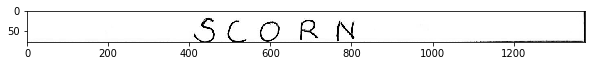

In [37]:
linedata = data1[490+5:571,:]
linedataL = dataL[490+5:571,:]
im = Image.fromarray(linedataL.astype('uint8'))
plt.figure(figsize=(10,10))
plt.imshow(im,interpolation='nearest',cmap='gray')

In the below code block we generate the starting and the ending positions of each letters in a given line and store them in the two lists, start and end. Once a start is found and the respective end is found, we display the sub-picture between these start and end locations, and between the upper and the lower ruled lines. We are removing stray lines/noises that are small, by removing the start and locations for that noise from the list, if the size of the sub-picture is less than 5% of the given height between the two ruled lines.

(76, 1376)
[412, 495, 574, 674, 764, 1373] [464, 541, 623, 718, 807]


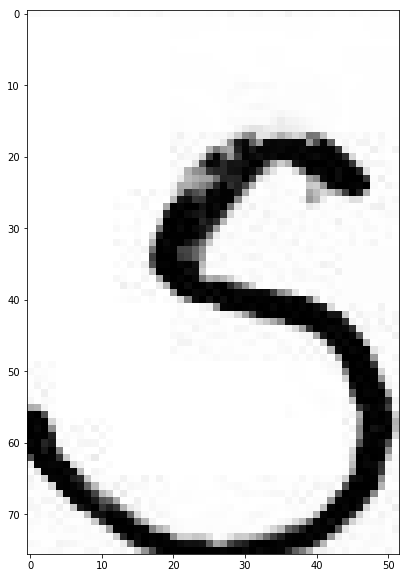

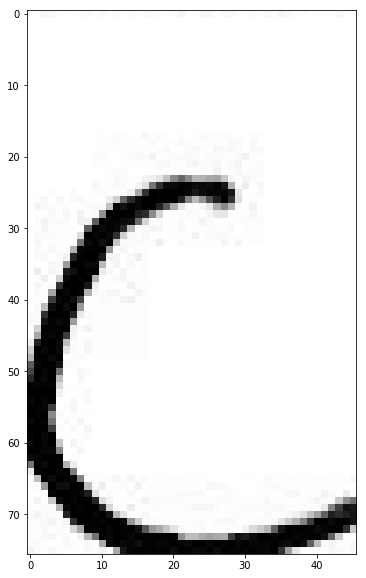

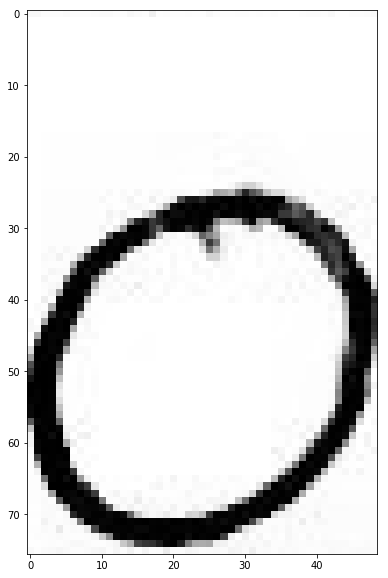

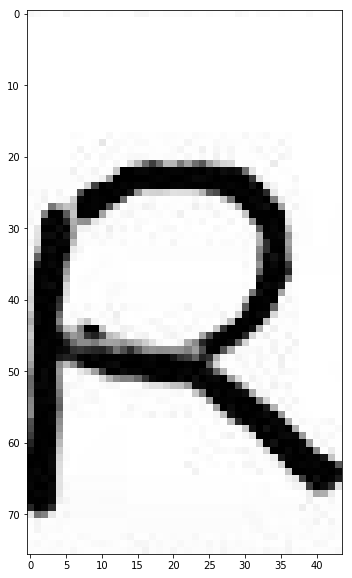

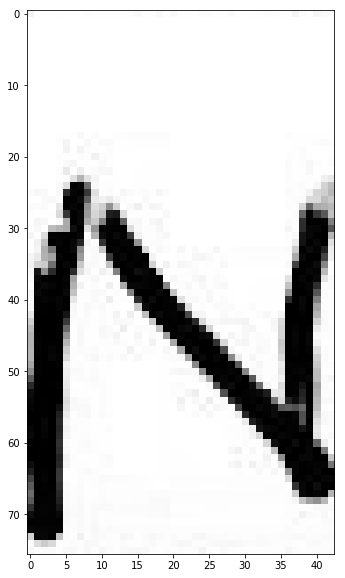

In [38]:
i=0
counter = -1
print(linedata.shape)
start = []
end = []
beginFlag = False
imageFlag = False
while i<linedata.shape[1]:
    if (np.sum(linedata[:,i])<linedata.shape[0]-5 and beginFlag == False):
        start.append(i)
        beginFlag = True
    elif(np.sum(linedata[:,i])>=linedata.shape[0] and beginFlag == True):
        if(np.sum(linedata[:,i+1])>=linedata.shape[0] or np.sum(linedata[:,i+2])>=linedata.shape[0]):
            end.append(i)
            if(end[counter] - start[counter]<0.05*linedata.shape[0]):
                start.pop(counter)
                end.pop(counter)
            else:
                counter += 1
                imageFlag = True
            beginFlag = False
    if(imageFlag == True and np.sum(linedata[:,start[counter]:end[counter]])<((linedata.shape[0]*(end[counter]-start[counter]))*0.70)):
        imageFlag = False
    if imageFlag == True:
        im = Image.fromarray(linedataL[:,start[counter]:end[counter]].astype('uint8'))
        plt.figure(figsize=(10,10))
        plt.imshow(im,interpolation='nearest',cmap='gray')
        imageFlag = False
    i+=1
if beginFlag == True and len(end) == 0:
    start = []
print(start,end)

In the below code snippet we take the sub-picture and modify it by placing it in a 28X28 multiple image, more or less in the center, and inverting the colors, and the iverting the image along the Y-axis at its center, and then rotating the image 90 degree anti-clockwise. This is done to make it match with the images in the dataset. We then resize the image to 28X28 so that it can be sent for prediction. The prediction is in terms of classes of the letters, and the letters are later identified by using the mapping list.

[19, 3, 15, 1, 14]
Word is 'SCORN' and predicted as : SCOAN


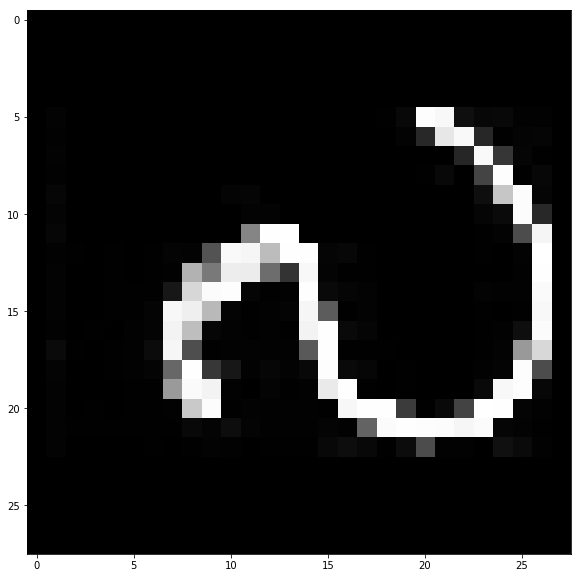

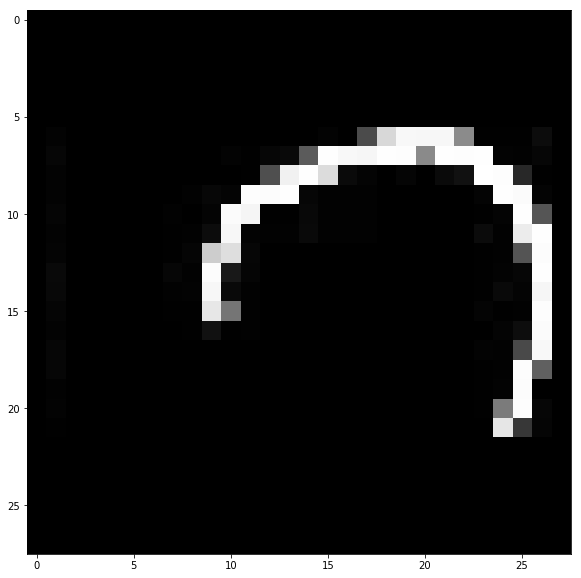

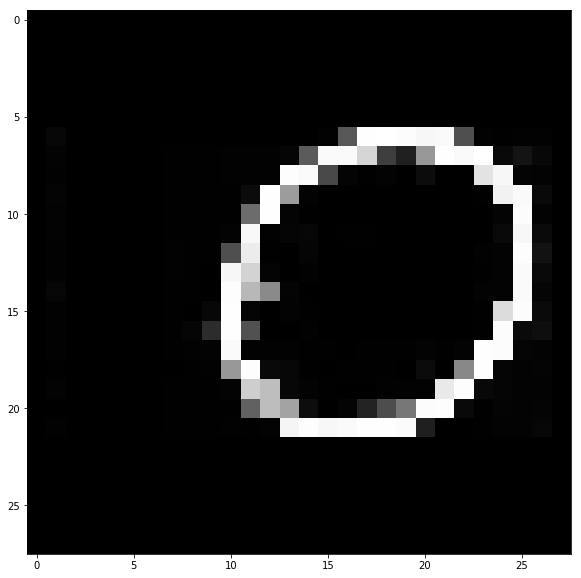

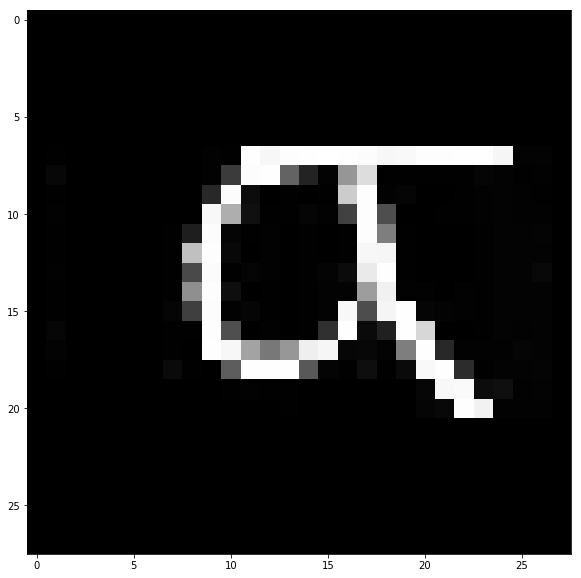

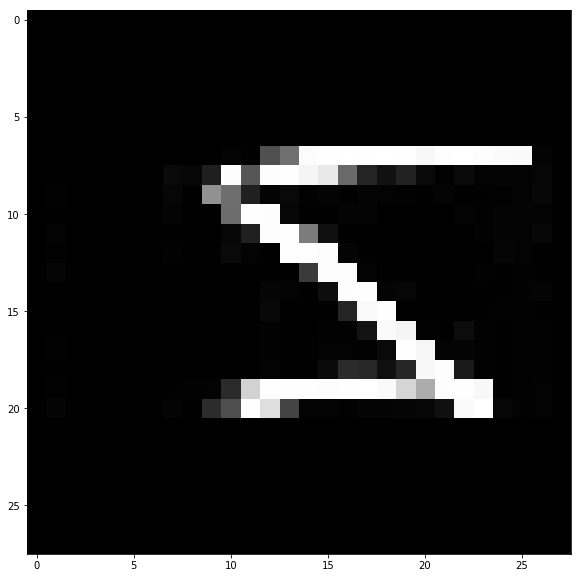

In [12]:
word = ''
index = 0
size = 0
Predictions = []
while(size < linedata.shape[0]):
    size += 28
for i in range(0,len(start)-1):
    midwidth = round(((size-(end[index]-start[index]))/2))
    midheight = round((size-linedata.shape[0])/2)
    linedata1 = linedata/255
    newimage = np.zeros((size,size))
    for i in range(0,linedata.shape[0]):
        for j in range(start[index],end[index]):
            newimage[midheight+i,midwidth+(j-start[index])] = abs(255-linedataL[i,j])
    scale = 28/newimage.shape[0]
    newimageL = rescale(newimage,scale , mode='reflect')
    
    im = Image.fromarray(newimageL.astype('uint8'))
    z = im 
    z = np.rot90(z)
    im2 = Image.fromarray(z.astype('uint8'))
    z = np.asarray(im2.transpose(Image.FLIP_TOP_BOTTOM))
    
    plt.figure(figsize=(10,10))
    plt.imshow(z,interpolation='nearest',cmap='gray')

    Y = cnn_model.predict(z.reshape(-1,28,28,1))
    Y = np.argmax(Y, axis = 1)
    Predictions.append(Y[0])
    index +=1
print(Predictions)
for i in range(0,len(Predictions)):
    word += (mapping[Predictions[i]])
print("Word is 'SCORN' and predicted as :",word)

As we can see from the below 4 code blocks, when an empty line is passed, no start and end locations were found.

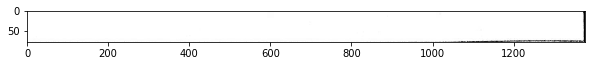

In [13]:
linedata = data1[408+5:490,:]
linedataL = dataL[408+5:490,:]
im = Image.fromarray(linedataL.astype('uint8'))
plt.figure(figsize=(10,10))
plt.imshow(im,interpolation='nearest',cmap='gray')

In [14]:
i=0
counter = -1
print(linedata.shape)
start = []
end = []
beginFlag = False
imageFlag = False
while i<linedata.shape[1]:
    if (np.sum(linedata[:,i])<linedata.shape[0]-5 and beginFlag == False):
        start.append(i)
        beginFlag = True
    elif(np.sum(linedata[:,i])>=linedata.shape[0] and beginFlag == True):
        if(np.sum(linedata[:,i+1])>=linedata.shape[0] or np.sum(linedata[:,i+2])>=linedata.shape[0]):
            end.append(i)
            counter += 1
            beginFlag = False
            imageFlag = True
    if(imageFlag == True and np.sum(linedata[:,start[counter]:end[counter]])<((linedata.shape[0]*(end[counter]-start[counter]))*0.70)):
        imageFlag = False
    if imageFlag == True:
        im = Image.fromarray(linedataL[:,start[counter]:end[counter]].astype('uint8'))
        plt.figure(figsize=(10,10))
        plt.imshow(im,interpolation='nearest',cmap='gray')
        imageFlag = False
    i+=1
if beginFlag == True and len(end) == 0:
    start = []
print(start,end)

(77, 1376)
[] []


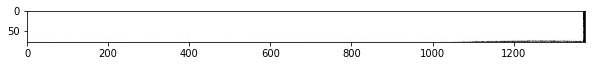

In [15]:
linedata = data1[326+5:408,:]
linedataL = dataL[326+5:408,:]
im = Image.fromarray(linedataL.astype('uint8'))
plt.figure(figsize=(10,10))
plt.imshow(im,interpolation='nearest',cmap='gray')

In [16]:
i=0
counter = -1
print(linedata.shape)
start = []
end = []
beginFlag = False
imageFlag = False
while i<linedata.shape[1]:
    if (np.sum(linedata[:,i])<linedata.shape[0]-5 and beginFlag == False):
        start.append(i)
        beginFlag = True
    elif(np.sum(linedata[:,i])>=linedata.shape[0] and beginFlag == True):
        if(np.sum(linedata[:,i+1])>=linedata.shape[0] or np.sum(linedata[:,i+2])>=linedata.shape[0]):
            end.append(i)
            counter += 1
            beginFlag = False
            imageFlag = True
    if(imageFlag == True and np.sum(linedata[:,start[counter]:end[counter]])<((linedata.shape[0]*(end[counter]-start[counter]))*0.70)):
        imageFlag = False
    if imageFlag == True:
        im = Image.fromarray(linedataL[:,start[counter]:end[counter]].astype('uint8'))
        plt.figure(figsize=(10,10))
        plt.imshow(im,interpolation='nearest',cmap='gray')
        imageFlag = False
    i+=1
if beginFlag == True and len(end) == 0:
    start = []
print(start,end)

(77, 1376)
[] []


Below we finally define a single function that is responsible for doing all the work shown in the above code blocks. Opening a picture, identifying the position of the lines, sepearting the characters and then predicting them, all of them is handled in this fucntion. The input parameter to this function is the name of the image.

In [10]:
def IHandS(imageName):
    img = Image.open(imageName)
    img.load()
    image1 = img.convert('1')
    data = np.asarray( img, dtype="int32" )
    data1 = np.asarray( image1, dtype="int32" )
    imageL = img.convert('L')
    dataL = np.asarray( imageL, dtype="int32" )

    im = Image.fromarray(dataL[:,:].astype('uint8'))
    plt.figure(figsize=(10,10))
    plt.imshow(im,interpolation='nearest',cmap='gray')
    lines=[]
    i=0
    while i<dataL.shape[0]:
        if np.sum(data1[i]) <= 0.80*data1.shape[1]:
            lines.append(i)
            i = i+(round((data1.shape[1]/100)*2))
        else:
            i += 1
    word = ""
    for linecounter in range(0,len(lines)-1):
        linedata = data1[lines[linecounter]+7:lines[linecounter+1],:]
        linedataL = dataL[lines[linecounter]+7:lines[linecounter+1],:]
        i=0
        counter = -1
        start = []
        end = []
        beginFlag = False
        imageFlag = False
        while i<linedata.shape[1]:
            if (np.sum(linedata[:,i])<linedata.shape[0]-5 and beginFlag == False):
                start.append(i)
                beginFlag = True
            elif(np.sum(linedata[:,i])>=linedata.shape[0] and beginFlag == True):
                if(np.sum(linedata[:,i+1])>=linedata.shape[0] or np.sum(linedata[:,i+2])>=linedata.shape[0]):
                    end.append(i)
                    if(end[counter] - start[counter]<0.05*linedata.shape[0]):
                        start.pop(counter)
                        end.pop(counter)
                    else:
                        counter += 1
                        imageFlag = True
                    beginFlag = False
            if(imageFlag == True and np.sum(linedata[:,start[counter]:end[counter]])<((linedata.shape[0]*(end[counter]-start[counter]))*0.70)):
                imageFlag = False
            i+=1
        if len(end) == 0 and len(start) == 1:
            start = []
            end = []
        if len(start) !=0:
            gaps = []
            for i in range(0,len(start)-2):
                gaps.append(start[i+1]-end[i])
            wordgap = 0
            if(max(gaps)>4*min(gaps)):
                wordgap = 4*min(gaps)
            else:
                wordgap = max(gaps)
            index = 0
            size = 0
            Predictions = []
            while(size < linedata.shape[0]):
                size += 28
            for i in range(0,len(start)):
                midwidth = round(((size-(end[index]-start[index]))/2))
                midheight = round((size-linedata.shape[0])/2)
                linedata1 = linedata/255
                newimage = np.zeros((size,size))
                for i in range(0,linedata.shape[0]):
                    for j in range(start[index],end[index]):
                        newimage[midheight+i,midwidth+(j-start[index])] = abs(255-linedataL[i,j])
                scale = 28/newimage.shape[0]
                newimageL = rescale(newimage,scale , mode='reflect')

                im = Image.fromarray(newimageL.astype('uint8'))
                z = im 
                z = np.rot90(z)
                im2 = Image.fromarray(z.astype('uint8'))
                z = np.asarray(im2.transpose(Image.FLIP_TOP_BOTTOM))

                Y = cnn_model.predict(z.reshape(-1,28,28,1))
                Y = np.argmax(Y, axis = 1)
                Predictions.append(Y[0])
                index +=1
            for i in range(0,len(Predictions)):
                word += (mapping[Predictions[i]])
                if (i<len(Predictions)-2 and gaps[i] > wordgap):
                    word += (mapping[0])
            if (len(Predictions)>0):
                word += (mapping[0])
        print("Processed Line : ", linecounter)
    print("Text Found is:", word)

We give another image over here, with three separate words, and we will see how it is handled by the program.

Processed Line :  0
Processed Line :  1
Processed Line :  2
Processed Line :  3
Processed Line :  4
Processed Line :  5
Processed Line :  6
Processed Line :  7
Processed Line :  8
Processed Line :  9
Processed Line :  10
Processed Line :  11
Processed Line :  12
Processed Line :  13
Processed Line :  14
Processed Line :  15
Processed Line :  16
Processed Line :  17
Processed Line :  18
Processed Line :  19
Processed Line :  20
Processed Line :  21
Text Found is: TIME FOA TAIAC 


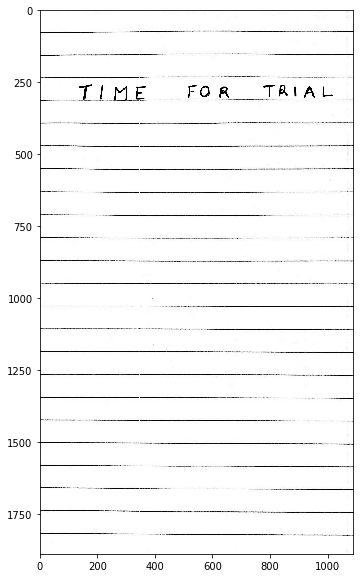

In [13]:
IHandS("LetterBig.jpg")

We can see from the two predictions made above, that the answer is pretty accurate and ususally goes wrong only when there is another chracter which is similar to our actual character in terms of shape and it goes wrong in predicting as it is not entirely sure which is more accurate. This could be avoided with better picture quality and better handwriting.

### Dataset issues

The primary issue faced was the way the pictures were represented in the database. As the images were presented with the letter being in the white color and the background being in black, which is the inverse of the regular way the text is found on the paper, some changes were necessary to compensate for this. We can see the differences between the two letters one from the real world image and one from the dataset below.

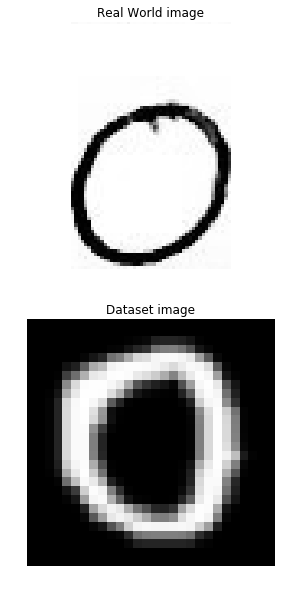

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.axis('off')
plt.title("Dataset image")
plt.imshow(dataletters.values[3,1:].reshape(28,28),interpolation='nearest',cmap='gray')
plt.subplot(2,1,1)
im = Image.fromarray(dataL[495:571,574:623].astype('uint8'))
plt.imshow(im,interpolation='nearest',cmap='gray')
plt.axis('off')
plt.title("Real World image")
plt.imshow(im,interpolation='nearest',cmap='gray')

When i started off with the project i thought that the way the images of the characters is represented in the regular upright fashion in the dataset, with the 28X28 pixels being represented as the columsn from 1 to 784, and 0th column being the target value. When i saw one of the images as can be seen below, i thought my assumptions were right.

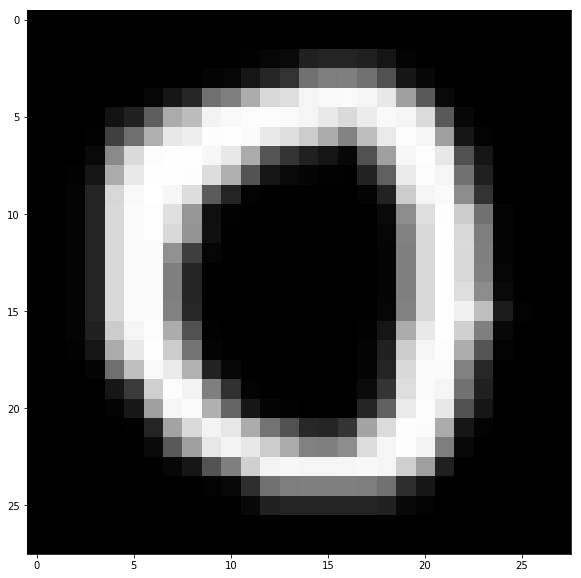

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(dataletters.values[3,1:].reshape(28,28),interpolation='nearest',cmap='gray')

However it turns out i was wrong as i was getting wrong predictions all the time. Then upon further exploration i realized that my assumpiton was wrong and the images are represented by rotating them by a 90 degree angle, in the clockwise direction. This was observed when i displayed the picture seen below from the dataset.

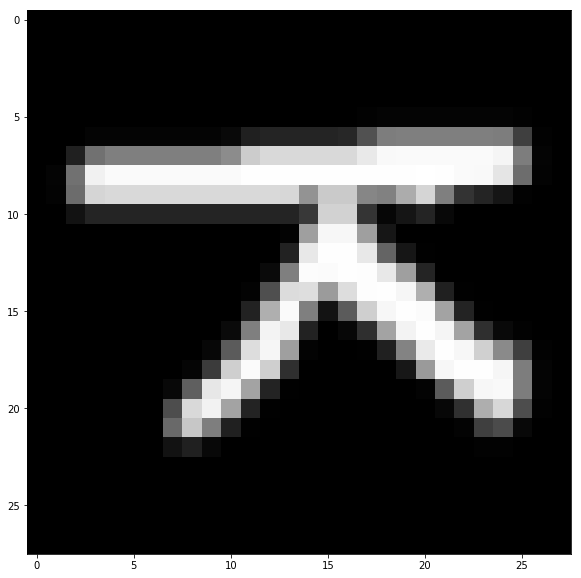

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(dataletters.values[140,1:].reshape(28,28),interpolation='nearest',cmap='gray')

And yet again i was getting wrong prediction. This got me wondering and looking into the dataset to realize how wrong i was all along. Turns out the image is actually rotated by 90 degree angle anti-clockwise and then flipped along the central axis, height wise. So to avoid heavy computations by changning by dataset, i just change the picture i was supposed to send for prediction to meet the way a picture is represented in the dataset, and i finally received good results.

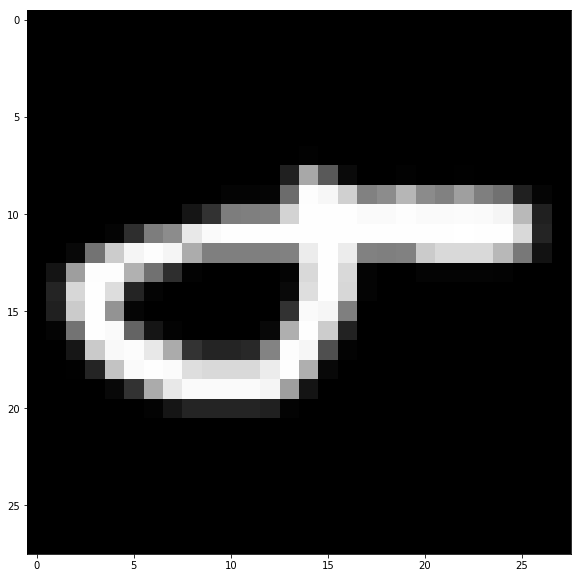

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(dataletters.values[2,1:].reshape(28,28),interpolation='nearest',cmap='gray')

I displayed the first 100 pictures from the dataset and realized, they all look like the symbols from the 'Predator' movie and got confused when i first them.

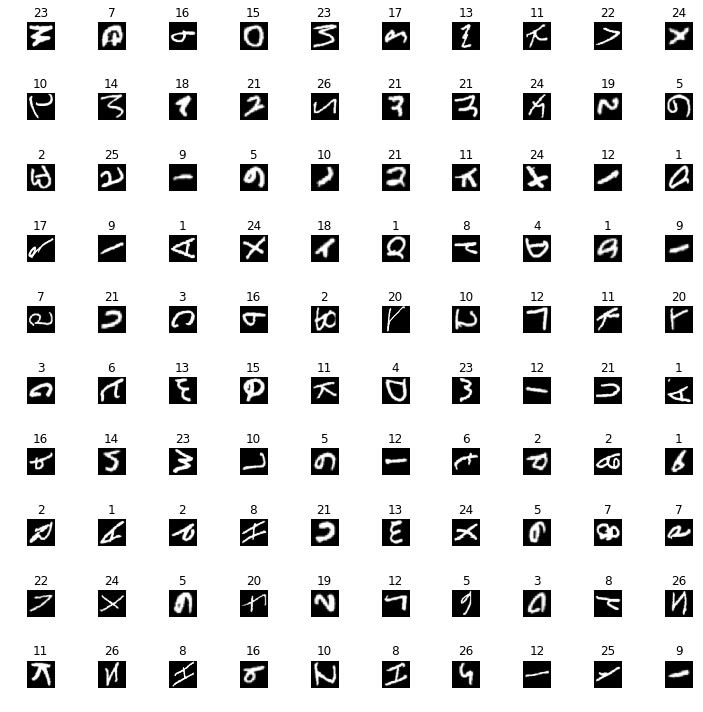

In [23]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(dataletters.values[i,1:].reshape((28,28)),interpolation='nearest',cmap='gray')
    plt.axis('off')
    plt.title(str(dataletters.values[i,0]))
plt.tight_layout()

### Initial Versions

I tried implementing the Multi Layer Perceptron classifier to identify the letters. I started off small where i implemented the MLP Classifier over the MNIST dataset of digits instead of the letters, to see how it fares.

In [24]:
f = open('mnist.pkl','rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

digitsXtrain = np.vstack([a.reshape((28, 28, 1))[np.newaxis, :, :, :] for a in train_set[0]])
digitsTtrain = np.array(train_set[1]).reshape((-1,1))

digitsXtrain.shape, digitsTtrain.shape

nEach = 1000
useThese = []
for digit in range(10):
    useThese += np.where(digitsTtrain == digit)[0][:nEach].tolist()
useThese = np.array(useThese)
np.random.shuffle(useThese)
datadigitsXtrain = digitsXtrain[useThese,:]
datadigitsTtrain = digitsTtrain[useThese,:]
del digitsXtrain # to save memory
del digitsTtrain

rowsShuffled = np.arange(datadigitsXtrain.shape[0])
np.random.shuffle(rowsShuffled)
nTrain = int(datadigitsXtrain.shape[0] * 0.8)
datadigitsXtrain = datadigitsXtrain.reshape((-1,784))
Xtraindigits = datadigitsXtrain[rowsShuffled[:nTrain],:]
Ttraindigits = datadigitsTtrain[rowsShuffled[:nTrain],:]
Xtestdigits = datadigitsXtrain[rowsShuffled[nTrain:],:]
Ttestdigits = datadigitsTtrain[rowsShuffled[nTrain:],:]

In [25]:
clf = MLPClassifier(alpha=0.000001)
clf.fit(Xtraindigits, Ttraindigits[:,0])

Ytraindigits = clf.predict(Xtraindigits)
Ytestdigits = clf.predict(Xtestdigits)

sum = 0
for i in range(len(Ttraindigits)):
    if(Ttraindigits[i]==[Ytraindigits[i]]):
        sum +=1;
print("Accuracy of MNIST training data using MLP CLassifier is : ",sum/len(Ttraindigits)*100)

sum = 0
for i in range(len(Ttestdigits)):
    if(Ttestdigits[i]==[Ytestdigits[i]]):
        sum +=1;
print("Accuracy of MNIST testing data using MLP CLassifier is : ",sum/len(Ttestdigits)*100)

Accuracy of MNIST training data using MLP CLassifier is :  100.0
Accuracy of MNIST testing data using MLP CLassifier is :  94.45


Now let us see the results when we use the Multi Layer Perceptron Classifier over the Letters database.

In [26]:
clf = MLPClassifier(alpha=0.00001)
Xtrain = dataletters.values[:,1:]
Ttrain = dataletters.values[:,0:1]
clf.fit(Xtrain, Ttrain[:,0])
Ytrain = clf.predict(Xtrain)
sum = 0
for i in range(len(Ttrain)):
    if(Ttrain[i]==[Ytrain[i]]):
        sum +=1;
print("Accuracy of EMNIST training data using MLP CLassifier is : ",sum/len(Ttrain)*100)

Accuracy of EMNIST training data using MLP CLassifier is :  82.0945945945946


As we can see the accuracy has fallen down to approximately 81% for the EMNIST dataset from 100% for the MNIST dataset, when we compare the accuracy for the training portion of the dataset itself. This is because more number of classes and simlarlity between the letters itself confuses the MLP Classifier.

However we see how it fares in predicting the same image as above, using the below code block.

Processed Line :  0
Processed Line :  1
Processed Line :  2
Processed Line :  3
Processed Line :  4
Processed Line :  5
Processed Line :  6
Processed Line :  7
Processed Line :  8
Processed Line :  9
Processed Line :  10
Processed Line :  11
Processed Line :  12
Processed Line :  13
Processed Line :  14
Processed Line :  15
Processed Line :  16
Processed Line :  17
Processed Line :  18
Processed Line :  19
Processed Line :  20
Text Found is: SCDAH 


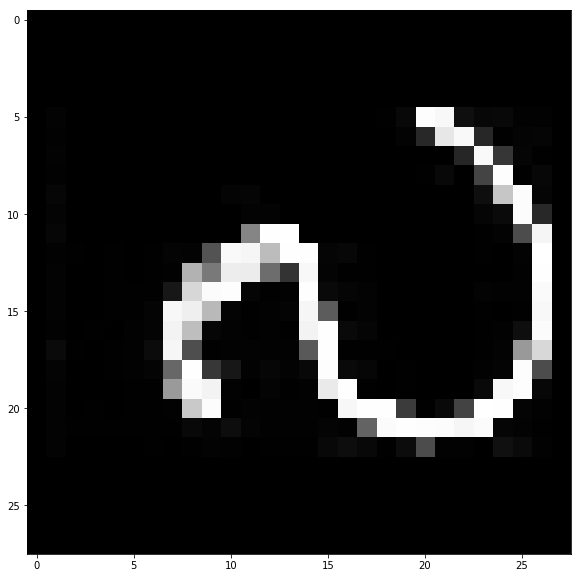

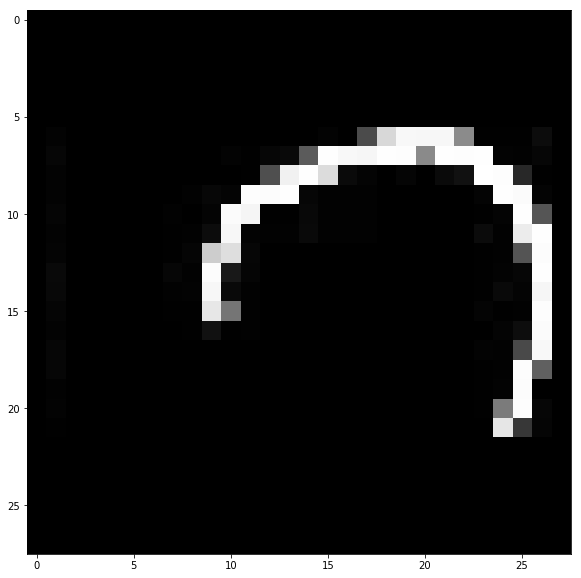

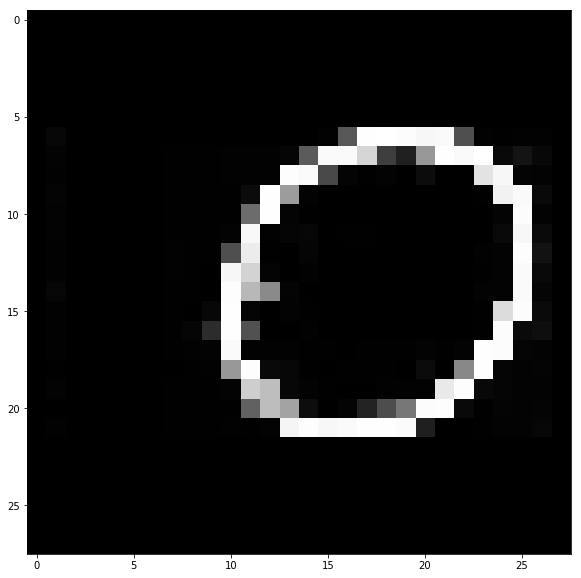

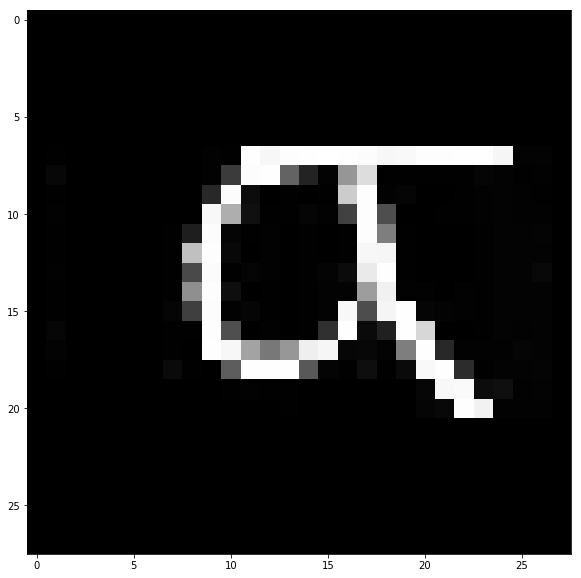

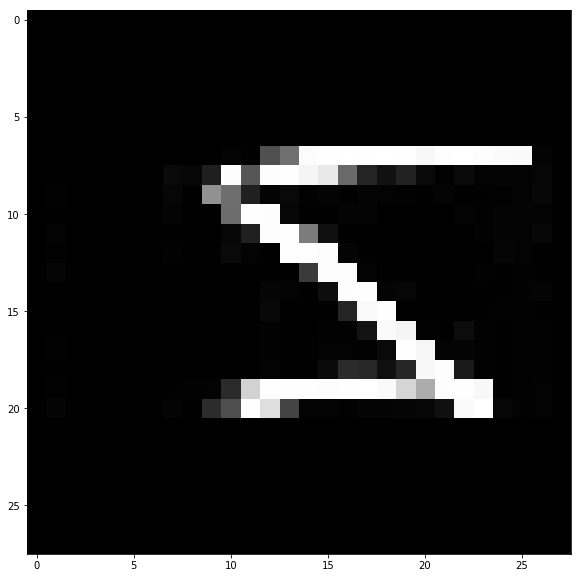

In [27]:
word = ""
for linecounter in range(0,len(lines)-1):
    linedata = data1[lines[linecounter]+5:lines[linecounter+1],:]
    linedataL = dataL[lines[linecounter]+5:lines[linecounter+1],:]
    i=0
    counter = -1
    start = []
    end = []
    beginFlag = False
    imageFlag = False
    while i<linedata.shape[1]:
        if (np.sum(linedata[:,i])<linedata.shape[0]-5 and beginFlag == False):
            start.append(i)
            beginFlag = True
        elif(np.sum(linedata[:,i])>=linedata.shape[0] and beginFlag == True):
            if(np.sum(linedata[:,i+1])>=linedata.shape[0] or np.sum(linedata[:,i+2])>=linedata.shape[0]):
                end.append(i)
                if(end[counter] - start[counter]<0.05*linedata.shape[0]):
                    start.pop(counter)
                    end.pop(counter)
                else:
                    counter += 1
                    imageFlag = True
                beginFlag = False
        if(imageFlag == True and np.sum(linedata[:,start[counter]:end[counter]])<((linedata.shape[0]*(end[counter]-start[counter]))*0.70)):
            imageFlag = False
        i+=1
    if len(end) == 0 and len(start) == 1:
        start = []
        end = []
    if len(start) == len(end)+1:
        start.pop()
    if len(start) !=0:
        gaps = []
        for i in range(0,len(start)-2):
            gaps.append(start[i+1]-end[i])
        wordgap = 0
        if(max(gaps)>4*min(gaps)):
            wordgap = 4*min(gaps)
        else:
            wordgap = max(gaps)
        index = 0
        size = 0
        Predictions = []
        while(size < linedata.shape[0]):
            size += 28
        for i in range(0,len(start)):
            midwidth = round(((size-(end[index]-start[index]))/2))
            midheight = round((size-linedata.shape[0])/2)
            linedata1 = linedata/255
            newimage = np.zeros((size,size))
            for i in range(0,linedata.shape[0]):
                for j in range(start[index],end[index]):
                    newimage[midheight+i,midwidth+(j-start[index])] = abs(255-linedataL[i,j])
            scale = 28/newimage.shape[0]
            newimageL = rescale(newimage,scale , mode='reflect')

            im = Image.fromarray(newimageL.astype('uint8'))
            z = im 
            z = np.rot90(z)
            im2 = Image.fromarray(z.astype('uint8'))
            z = np.asarray(im2.transpose(Image.FLIP_TOP_BOTTOM))

            plt.figure(figsize=(10,10))
            plt.imshow(z,interpolation='nearest',cmap='gray')
            Y = clf.predict(z.reshape(1,-1))
            Predictions.append(Y[0])
            index +=1
        for i in range(0,len(Predictions)):
            word += (mapping[Predictions[i]])
            if (i<len(Predictions)-2 and gaps[i] > wordgap):
                word += (mapping[0])
        if (len(Predictions)>0):
            word += (mapping[0])
    print("Processed Line : ", linecounter)
print("Text Found is:", word)

As can be seen from the above predicitons, the result is not at all accurate as most of the wrongly predicted words have no simlarlity between themselves and the actual word. In the case of Convolutional Neural Networks, the predictions go wrong,, only when there is a letter very similar to the actual letter itself.

The Multi Layer Perceptron fails to get the predictions right in this case because it depends on the relative postion of the white and the black pixels. So if the letter is slightly up or down in the picture to be predicted, it goes wrong, as it would not consider the entire image for its actual prediction. In case of the Convolutional Neural Network, the postion of the letter in the image will not matter, but the shape of the image itself matters, hence even when the picture is in a different location than anticipated, it still gets most of the answers right.

## References

A lot of sites and paper were refered to get general ideas as to how to use the images of letters to get the prediction, how to use Keras, Multi Layer Perceptron, etc. Below are a few of them that were used for reference.

1. [Convolutional Neural Networks in Python with Keras](https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python )

2. [Telugu Character Recognition using CNN](https://github.com/Harathi123/Telugu-Character-Recognition-using-CNN)

3. [Keras used for building Convolutional Neural Networks](https://keras.io)

4. [HDF5 used for saving the trained Convolutional Neural Network](http://docs.h5py.org/en/latest/)

5. [EMNIST dataset](https://www.kaggle.com/crawford/emnist)

6. [Multi Layer Perceptron Classifier in Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

7. [Using images in Python](http://www.imagexd.org/tutorial/lessons/0_images_are_arrays.html)

In [28]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('ProjectCS445.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file ProjectCS445.ipynb is 2058
